In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix, triu, spdiags
from scipy.integrate import solve_ivp
from scipy.sparse.linalg import spsolve, splu
import numpy.matlib
import matplotlib.pylab as plt
from matplotlib import animation, rc
from matplotlib import cm
import sys
import time

In [2]:
f = lambda x: np.exp(-(x-5)**2) #Define the Initial Condition
L = 10 #Define the length, L
t = np.arange(0, 10+0.5, 0.5)
x = np.arange(-L,L,0.1) #Our x domain.
N = len(x)

In [3]:
e = np.ones((N))
Bin = np.array([e, -e, e, -e])
d = np.array([-N+1, -1, 1, N-1])
A = spdiags(Bin, d, N, N, format='csc')/0.2
y0 = f(x) # Initial condition evaluated on our domain x. 

In [4]:
print(A.toarray())

[[ 0.  5.  0. ...  0.  0. -5.]
 [-5.  0.  5. ...  0.  0.  0.]
 [ 0. -5.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  5.  0.]
 [ 0.  0.  0. ... -5.  0.  5.]
 [ 5.  0.  0. ...  0. -5.  0.]]


In [5]:
def advectionPDE(t, u, A):
    A = 0.5*A
    u_t = A@u
    return u_t

tic = time.time()
sol = solve_ivp(lambda t,u: advectionPDE(t, u, A), t_span=[t[0], t[-1]], y0=y0, method='RK45', t_eval=t)
toc = time.time()
print(toc-tic)
sol = sol.y

0.014936208724975586


In [6]:
A1 = np.copy(A.toarray())
A2 = sol

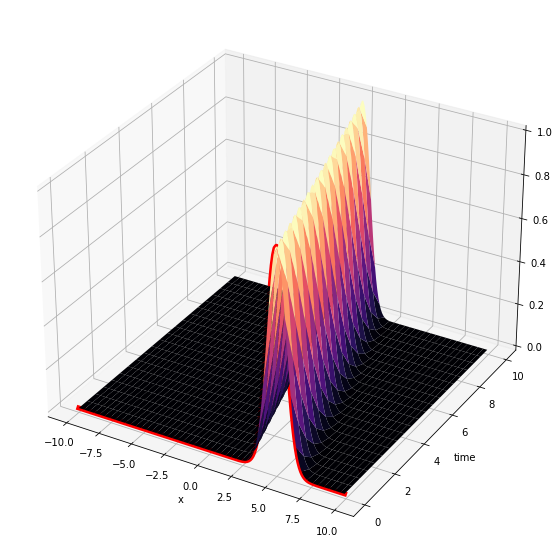

In [7]:
X, T = np.meshgrid(x,t)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize =(25, 10))
surf = ax.plot_surface(X, T, sol.T,cmap='magma')
ax.plot3D(x, 0*x, f(x),'-r',linewidth=5)
plt.xlabel('x')
plt.ylabel('time')
plt.show()

In [8]:
HA = np.copy(A1)
HA = sp.csr_matrix(HA)
HA[0:141, :] = 0

/Users/sunhaolou/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [9]:
def advectionPDE2(t, u, A, HA):
    c = 1+2*np.sin(5*t)
    A = np.dot(c, A) - HA
    u_t = A@u
    return u_t

tic = time.time()
sol = solve_ivp(lambda t,u: advectionPDE2(t, u, A, HA), t_span=[t[0], t[-1]], y0=y0, method='RK45', t_eval=t)
toc = time.time()
print(toc-tic)
sol = sol.y

0.4467329978942871


In [10]:
A3 = sol

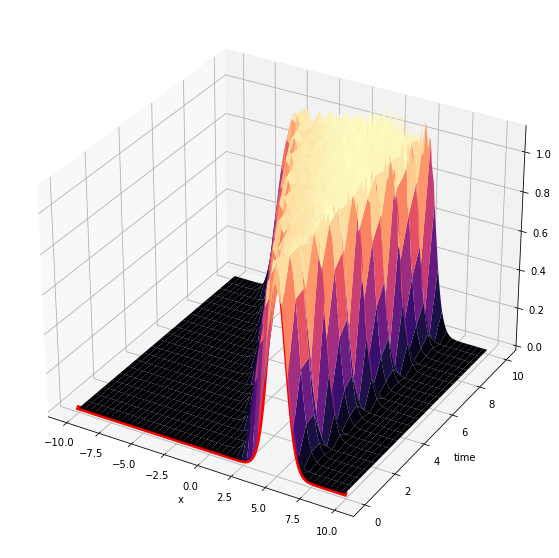

In [11]:
X, T = np.meshgrid(x,t)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize =(25, 10))
surf = ax.plot_surface(X, T, sol.T,cmap='magma')
ax.plot3D(x, 0*x, f(x),'-r',linewidth=5)
plt.xlabel('x')
plt.ylabel('time')
plt.show()

In [12]:
m = 64 # N value in x and y directions
n = m*m # total size of matrix
h = 20/64
e1 = np.ones(n) # vector of ones
d = np.ones(n)
d[0] = -0.5
Low1 = np.tile(np.concatenate((np.ones(m-1), [0])), (m,)) # Lower diagonal 1
Low2 = np.tile(np.concatenate(([1], np.zeros(m-1))), (m,)) #Lower diagonal 2
                                    # Low2 is NOT on the second lower diagonal,
                                    # it is just the next lower diagonal we see
                                    # in the matrix.

Up1 = np.roll(Low1, 1) # Shift the array for spdiags
Up2 = np.roll(Low2, m-1) # Shift the other array

A = sp.spdiags([e1, e1, Low2, Low1, -4*d, Up1, Up2, e1, e1],
                         [-(n-m), -m, -m+1, -1, 0, 1, m-1, m, (n-m)], n, n, format='csc')
A = A/h**2

In [13]:
# print(A.toarray()[0:9,0:9])

In [14]:
B = sp.spdiags([e1, -1*e1, e1, -1*e1],
                         [-(n-m), -m, m, (n-m)], n, n, format='csc')
B = B/(2*h)

In [15]:
# print(B.toarray())

In [16]:
C = sp.spdiags([Low2, -1*Low1, Up1, -1*Up2,],
                         [-m+1, -1, 1, m-1], n, n, format='csc')
C = C/(2*h)

In [17]:
# print(C.toarray())

In [18]:
A4 = np.copy(A.toarray())
A5 = np.copy(B.toarray())
A6 = np.copy(C.toarray())

In [19]:
f = lambda x,y: np.exp(-2*x**2 - (y**2/20)) #Define the Initial Condition
L = 10 #Define the length, L
t = np.arange(0, 4+0.5, 0.5)
x = np.arange(-L,L,h)
y = np.arange(-L,L,h)
yv, xv = np.meshgrid(x, y)
w0 = f(xv, yv)
w0 = np.reshape(w0, (4096, ))

In [20]:
def vor_stream_Gauss(t, w, A, B, C):
    w = np.reshape(w, (4096, ))
    psi = sp.linalg.spsolve(A, w)
    w_t = 0.001*A@w - (B@psi)*(C@w) + (C@psi)*(B@w)
    return w_t

In [21]:
tic = time.time()
sol = solve_ivp(lambda t,w: vor_stream_Gauss(t, w, A, B, C), t_span=[0, 4], y0=w0, method='RK45', t_eval=t)
toc = time.time()
time_Gauss = toc - tic
print(time_Gauss)
sol = sol.y.T

0.7768821716308594


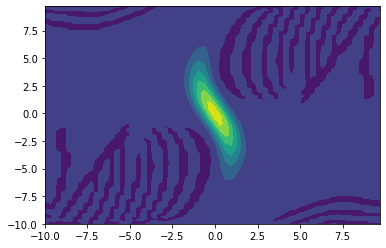

In [22]:
plt.contourf(xv, yv, np.reshape(sol[8, :], (64,64)))
plt.show()

In [23]:
sol.shape

(9, 4096)

In [24]:
A7 = sol

In [25]:
def vor_stream_LU(t, w, A, B, C):
    w = np.reshape(w, (4096, ))
    psi = PLU.solve(w)
    w_t = 0.001*A@w - (B@psi)*(C@w) + (C@psi)*(B@w)
    return w_t

In [26]:
tic = time.time()
PLU = splu(A)
sol = solve_ivp(lambda t,w: vor_stream_LU(t, w, A, B, C), t_span=[0, 4], y0=w0, method='RK45', t_eval=t)
toc = time.time()
time_LU = toc - tic
print(time_LU)
sol = sol.y.T

0.08113908767700195


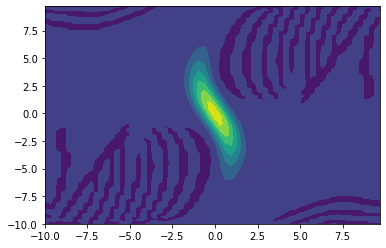

In [27]:
plt.contourf(xv, yv, np.reshape(sol[8, :], (64,64)))
plt.show()

In [28]:
sol.shape

(9, 4096)

In [29]:
A8 = sol

In [30]:
A9 = np.reshape(sol, (9, 64, 64))

In [31]:
print(time_Gauss/time_LU)

9.574696904696141


In [32]:
t = np.arange(0, 4+0.1,0.1)

In [33]:
sol = solve_ivp(lambda t,w: vor_stream_LU(t, w, A, B, C), t_span=[0, 4], y0=w0, method='RK45', t_eval=t)

In [34]:
sol = sol.y.T

In [35]:
result = np.reshape(sol, (41, 64, 64))

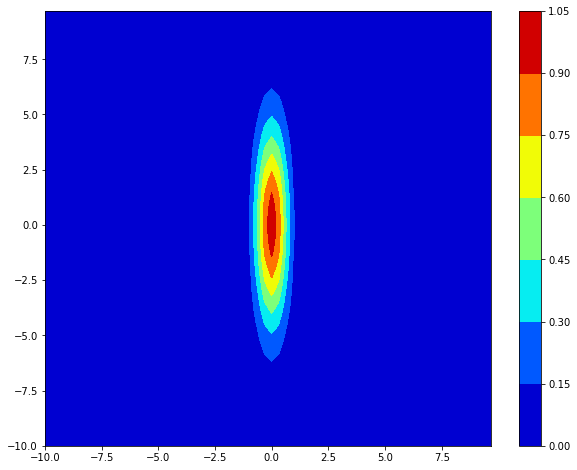

In [36]:
rc('animation',html = 'html5')
fig,ax=plt.subplots(1,1)
fig.set_size_inches(10, 8, True)
cp = ax.contourf(xv, yv, result[0, :, :], cmap=cm.jet)
fig.colorbar(cp)
title = ax.text(0.5,0.85,"",bbox={'facecolor':'w','alpha':0.1,"pad":0.2},transform = ax.transAxes,ha='center')

In [37]:
def animate(i):
    ax.contourf(xv, yv, result[i, :, :], cmap=cm.jet)
    ax.set_title("Vorticity at time t = %0.2f" % t[i])

In [38]:
ani = animation.FuncAnimation(fig, animate, frames = range(len(t)), blit = False,save_count=sys.maxsize)
plt.show()

In [39]:
ani

In [40]:
writermp4=animation.FFMpegWriter(fps=10)
ani.save('Vorticity_sol.mp4',writer = writermp4)